# Chest X-Ray Image classifier to detect pneumonia

Dataset:
> Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, v2
> http://dx.doi.org/10.17632/rscbjbr9sj.2

In [0]:
from google.colab import drive
drive.mount("/content/drive")

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.xception import Xception
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from PIL import Image

## Data augmentation

In [0]:
trainDataDir = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/train/'
validationDataDir = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/test/'


batchSize = 16
width = 224
height = 224


trainDataGen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=9,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validationDataGen = ImageDataGenerator(
    rescale=1./255
)

trainGenerator = trainDataGen.flow_from_directory(
    trainDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='grayscale'
)

validationGenerator = validationDataGen.flow_from_directory(
    validationDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model creation

Simple CNN without Zero Padding and Batch Normalization

In [0]:
model = Sequential([
    Conv2D(32, (3,3), activation=relu, input_shape=(width, height, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation=relu),  
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation=relu), 
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation=relu),
    Dropout(0.5),
    Dense(512, activation=relu),
    Dense(1, activation=sigmoid)
])

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)       147584    
__________

Class weight balancing is not needed, because we want to reduce the false negative cases, and the nature of the dataset is good for the case

In [0]:
earlyStopping = EarlyStopping(
    monitor='val_acc',
    mode='auto', 
    baseline=None, 
    restore_best_weights=True, 
    patience = 8,
    verbose = 1
)

stepsValidation = validationGenerator.samples // batchSize
stepsTraining = trainGenerator.samples // batchSize

# class_weight = {0.0 : 0.74,
#                1.0 : 0.26}

history = model.fit_generator(
    generator = trainGenerator,
    steps_per_epoch = stepsTraining,
    epochs=80,
    validation_data = validationGenerator,
    validation_steps = stepsValidation,
#    class_weight=class_weight,
    callbacks=[earlyStopping]
)

Epoch 1/80
326/326 [==============================] - 78s 241ms/step - loss: 0.4266 - acc: 0.8073 - val_loss: 0.6021 - val_acc: 0.6474
Epoch 2/80
326/326 [==============================] - 79s 242ms/step - loss: 0.3190 - acc: 0.8579 - val_loss: 0.3912 - val_acc: 0.8285
Epoch 3/80
326/326 [==============================] - 78s 238ms/step - loss: 0.2802 - acc: 0.8852 - val_loss: 0.3691 - val_acc: 0.8542
Epoch 4/80
326/326 [==============================] - 80s 244ms/step - loss: 0.2590 - acc: 0.8911 - val_loss: 0.5315 - val_acc: 0.7484
Epoch 5/80
326/326 [==============================] - 78s 239ms/step - loss: 0.2530 - acc: 0.9003 - val_loss: 0.3475 - val_acc: 0.8654
Epoch 6/80
326/326 [==============================] - 78s 238ms/step - loss: 0.2416 - acc: 0.9011 - val_loss: 0.3161 - val_acc: 0.8734
Epoch 7/80
326/326 [==============================] - 78s 239ms/step - loss: 0.2408 - acc: 0.9007 - val_loss: 0.3278 - val_acc: 0.8638
Epoch 8/80
326/326 [==============================] - 8

## Training history and final validation: confusion matrix , ROC curve and classification report

In [0]:
def predictClasses(predictions):
    valResult = predictions.copy()
    valResult[valResult <= 0.5] = 0
    valResult[valResult > 0.5] = 1
    return valResult

def plotHistory(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss history')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plotConfusionMatrix(predictions, labels):
    valResult = predictClasses(predictions)
    confMatrixdf = pd.DataFrame(
        confusion_matrix(labels, valResult),
        index=["Exp. Normal", "Exp. Pneumonia"],
        columns=["Pred. Normal", "Pred. Pneumonia"]
    )

    plt.title("Confusion Matrix")
    sn.heatmap(confMatrixdf, annot=True, annot_kws={"size" : "20"})

def plotROCCurve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, 'b')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show()

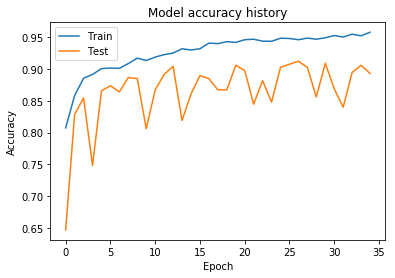

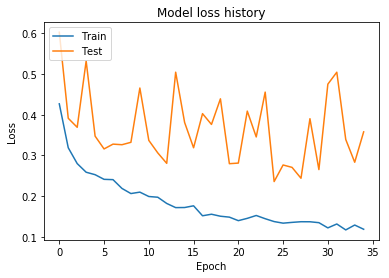

In [0]:
plotHistory(history)

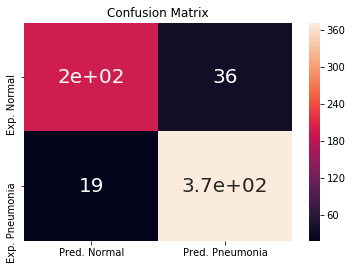

In [0]:
prediction = model.predict_generator(validationGenerator, stepsValidation)

plotConfusionMatrix(
    prediction, 
    validationGenerator.classes
)

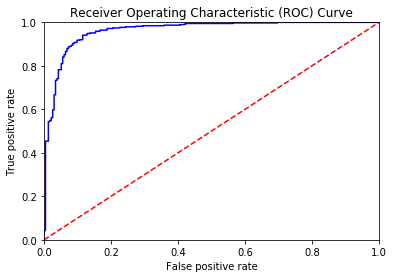


Report: 
               precision    recall  f1-score   support

      Normal       0.91      0.85      0.88       234
   Pneumonia       0.91      0.95      0.93       390

   micro avg       0.91      0.91      0.91       624
   macro avg       0.91      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



In [0]:
plotROCCurve(
    prediction,
    validationGenerator.classes
)

print(
    "\nReport: \n", 
    classification_report(
        validationGenerator.classes, 
        predictClasses(prediction), 
        target_names = ["Normal", "Pneumonia"]
    )
)

## Transfer Learning - Xception

First, we need two new generators, because Xception needs 3 channel images (RGB).

In [0]:
xceptionTrainGenerator = trainDataGen.flow_from_directory(
    trainDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='rgb'
)

xceptionValidationGenerator = validationDataGen.flow_from_directory(
    validationDataDir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Let's create our new model, using VGG convolutional layers and our own output layers.

In [0]:
xceptionConv = Xception(include_top=False, weights="imagenet", input_shape=(224,224,3))

x = Flatten()(xceptionConv.output)
x = Dropout(0.5)(x)
x = Dense(512, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=relu)(x)
output = Dense(1, activation=sigmoid)(x)


xceptionModel = Model(inputs=xceptionConv.input,outputs=output)

xceptionModel.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

xceptionModel.summary()

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
_______________________________________________________

In [0]:
xceptionEarlyStopping = EarlyStopping(
    monitor='val_acc',
    mode='auto', 
    baseline=None, 
    restore_best_weights=True, 
    patience = 8,
    verbose = 1
)

xceptionHistory = xceptionModel.fit_generator(
    generator = xceptionTrainGenerator,
    steps_per_epoch = stepsTraining,
    epochs=40,
    validation_data = xceptionValidationGenerator,
    validation_steps = stepsValidation,
    callbacks=[xceptionEarlyStopping]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
326/326 [==============================] - 1643s 5s/step - loss: 0.6681 - acc: 0.7425 - val_loss: 0.6559 - val_acc: 0.6250
Epoch 2/40
326/326 [==============================] - 266s 816ms/step - loss: 0.4925 - acc: 0.7427 - val_loss: 1.5127 - val_acc: 0.6250
Epoch 3/40
326/326 [==============================] - 266s 817ms/step - loss: 0.4853 - acc: 0.7427 - val_loss: 0.6637 - val_acc: 0.6250
Epoch 4/40
326/326 [==============================] - 267s 818ms/step - loss: 0.4513 - acc: 0.7456 - val_loss: 0.7067 - val_acc: 0.3862
Epoch 5/40
326/326 [==============================] - 268s 821ms/step - loss: 0.2732 - acc: 0.8842 - val_loss: 0.6470 - val_acc: 0.7308
Epoch 6/40
326/326 [==============================] - 267s 819ms/step - loss: 0.1849 - acc: 0.9333 - val_loss: 0.2755 - val_acc: 0.8894
Epoch 7/40
326/326 [==============================] - 269s 825ms/step - loss: 0.1722 - acc: 0.9417 - val_loss: 3.6715 - val_acc: 0.7131
Ep

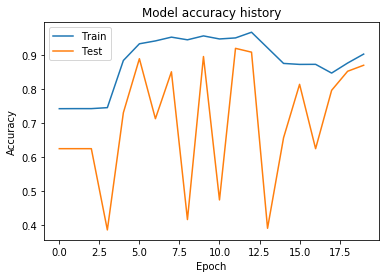

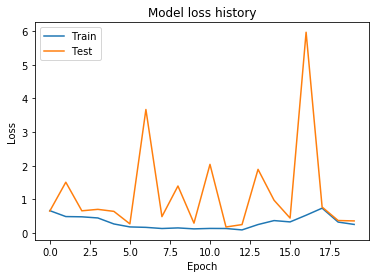

In [21]:
plotHistory(xceptionHistory)

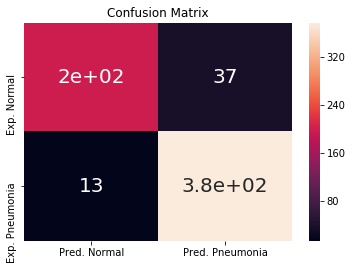

In [23]:
xceptionPrediction = xceptionModel.predict_generator(xceptionValidationGenerator, stepsValidation)

plotConfusionMatrix(
    xceptionPrediction, 
    xceptionValidationGenerator.classes
)

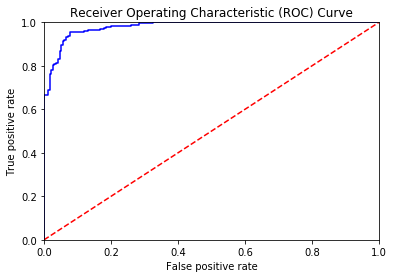


Report: 
               precision    recall  f1-score   support

      Normal       0.94      0.84      0.89       234
   Pneumonia       0.91      0.97      0.94       390

   micro avg       0.92      0.92      0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



In [24]:
plotROCCurve(
    xceptionPrediction,
    xceptionValidationGenerator.classes
)

print(
    "\nReport: \n", 
    classification_report(
        xceptionValidationGenerator.classes, 
        predictClasses(xceptionPrediction), 
        target_names = ["Normal", "Pneumonia"]
    )
)

We can see than the pretained convolutional layers of the Xception Architecture with Imagenet dataset can give some interesting results, given the purpose of the Imagenet pre-trained model (1000 classes classification). However, It's overfitting much more than our custom model.

## Small testing

In [0]:
def testImage(model, file, title, width=224, height=224, color=False):
    image = Image.open(file)
    if color:
        image = image.convert("RGB")
    plt.imshow(np.asarray(image))
    data = np.array(image.resize((width,height), Image.ANTIALIAS)).reshape(1, width, height, 3 if color else 1)/255
    plt.title(title)
    plt.xlabel("Prediction: " + ("PNEUMONIA" if model.predict(data) > 0.5 else "NORMAL"))
    plt.show()

In [0]:
testImage(
    model = model,
    file = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
    title = "Pneumonia sample - Custom CNN"
)

testImage(
    model = model,
    file = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg',
    title = "Normal sample - Custom CNN"
)

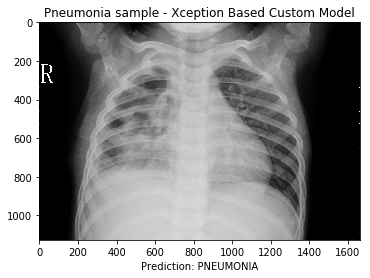

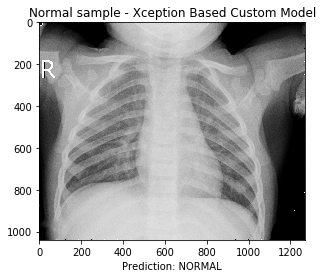

In [54]:
testImage(
    model = xceptionModel,
    file = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg',
    title = "Pneumonia sample - Xception Based Custom Model",
    color=True
)

testImage(
    model = xceptionModel,
    file = '/content/drive/My Drive/Colab Notebooks/datasets/pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg',
    title = "Normal sample - Xception Based Custom Model",
    color=True
)